# **Homework 2 Due on Friday October 7 23h59**


# **Problem 0: Moving the lab to your folder**

Duplicate this notebook (as you won't have write permission to this) to your Google Drive. 
This can be done by clicking on *File Menu - Save a copy in Drive*

Run to mount your google drives:

In [1]:
os.chdir('/Users/michaelzakariaie/Desktop/Hopkins/Fall/MLSP/HW2')
DataPath = os.getcwd() + '/data'


Your drive would be accessed as '/content/drive/MyDrive' for Colab. We suggest putting your data and creating a 'results' folder somewhere in the drive. The 'results' folder could be used for storing the required outputs.   

Then, load all the imports you plan to use later; 
just do not use those built-in functions which directly solve the problem. 

In [2]:
# You may need to run "pip3 install scikit-image"
import matplotlib.pyplot as plt
import matplotlib.patches as patches #just used to draw rectangles
from skimage.transform import rescale, resize
from scipy.signal import convolve2d
from sklearn.preprocessing import normalize
from skimage.io import imread
import numpy as np
import os


# You may not import any other libraries.

In [3]:
# Load Data
faces = []

for image in os.listdir(DataPath + '/lfw_1000/'):
  faces.append(imread(DataPath +'/lfw_1000/' + image).flatten())

faces = np.asarray(faces)
print(np.shape(faces))

(1071, 4096)


# **Problem 1: Simple Face Detector**
Implement a simple face detector that can detect faces in group photos of people.


In [4]:
# Perform PCA/Extract Eigenfaces

# 1. Center Faces
mean = faces.mean()
demean = lambda x: x - mean
centered_faces = demean(faces)

# 2. Compute correlation Matrix
correlation_matrix = np.matmul(centered_faces.T, centered_faces)

# 3. Eigen Decomposition
Lambda, U = np.linalg.eig(correlation_matrix)
Lambda = np.real(Lambda)
U = np.real(U)
v = np.matmul(centered_faces, U)

v = normalize(v,norm='l2',axis=0)

first_face = v[0]

In [5]:
print(np.shape(first_face))
print(np.shape(v))

(4096,)
(1071, 4096)


In [6]:
def resizeImage(image, scale):

    offset = 1/scale
    length, width = np.shape(image)
    length = round(length * scale) - int(scale)
    width = round(width * scale) - int(scale)
    
    scaled_image = np.zeros((length, width))
    for row in range(length):
      for col in range(width):
        scaled_image[row,col] = image[round(row * offset), round(col * offset)]
            
    return scaled_image

def greyscale(face):
  if (len(np.shape(face)) == 3): #rgb images
    return np.floor(np.divide(np.sum(face,axis=2),3)) # add r + g + b and divide by 3
  return face



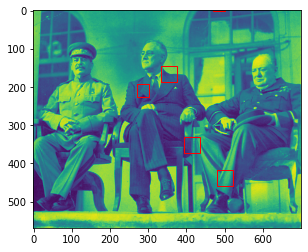

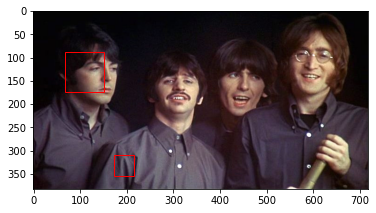

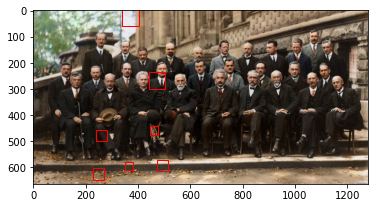

<ipython-input-9-52772b92999b>:31: RuntimeWarning: invalid value encountered in double_scalars
  match_score = np.dot(potential_face, first_face) / np.linalg.norm(potential_face)


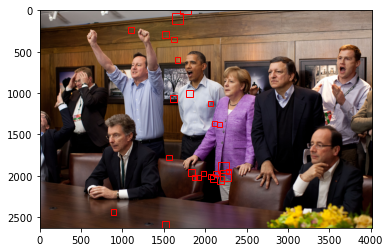

In [9]:
scales = [0.5,0.75,1,1.5,2.0]
spacing = 10
single_scale_percentile = 97
all_scales_percentile = 85
peak_merge_threshold = 40

# for each group photo
for image in os.listdir(DataPath + '/groups'): 
  group = imread(DataPath +'/groups/' + image)

  fig, ax = plt.subplots()
  ax.imshow(group)
  
  group = greyscale(group)
  potential_faces = []

  # Plotting
  

  # for each scale of the group photo
  for scale in scales:
    
    scaledGroup = resizeImage(group, scale)
    length, width = np.shape(scaledGroup)
    potential_faces_scale = []

    # iterate over each 64x64 square and find potential faces
    for i in range(0, length - 64, spacing):
      for j in range(0, width - 64, spacing):
        potential_face = scaledGroup[i:i+64, j:j+64].flatten()
        match_score = np.dot(potential_face, first_face) / np.linalg.norm(potential_face)

        # tlX coord, tlY coord, scale, score, center x coord, center y coord
        potential_faces_scale.append([round(i/scale), round(j/scale), scale, match_score, round(i/scale + 32/scale), round(j/scale + 32/scale)]) 

    # Evaluate Scores
    scores = [potential_face[3] for potential_face in potential_faces_scale]
    minimum_score = np.percentile(scores, single_scale_percentile)
    potential_faces_scale = [potential_face for potential_face in potential_faces_scale if potential_face[3] >= minimum_score]
    potential_faces.extend(potential_faces_scale)


  # Peak Matching
  merged_peaks = []
  for potential_face1 in potential_faces:
    peak = True
    # see if any nearby faces have higher match scores
    for potential_face2 in potential_faces:
      if potential_face1 == potential_face2: # dont compare to yourself - make sure this actually does what it's suppose to do
        continue

      # if other face is within the neighborhood
      if abs(potential_face1[4] - potential_face2[4]) <= peak_merge_threshold: # check distance of x coords
        if abs(potential_face1[5] - potential_face2[5]) <= peak_merge_threshold: # check distance of y coords
          if potential_face2[3] > potential_face1[3]:
            peak = False

    if peak: 
      merged_peaks.append(potential_face1)
      # rect = patches.Rectangle((potential_face1[0], round(potential_face1[1] - 64/potential_face1[2])), round(64/potential_face1[2]), round(64/potential_face1[2]), linewidth=1, edgecolor='r', facecolor='none')
      # ax.add_patch(rect)

  # Evaluate Scores Again
  scores = [potential_face[3] for potential_face in merged_peaks]
  minimum_score = np.percentile(scores, all_scales_percentile)
  merged_peaks = [potential_face for potential_face in merged_peaks if potential_face[3] >= minimum_score]

  for face in merged_peaks:
    rect = patches.Rectangle((face[0], round(face[1] - 64/face[2])), round(64/face[2]), round(64/face[2]), linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)


  plt.show()

  

# faces only in first half?????????????????????????????
# only use scale with highest score? or 2 scales? ???? ??????????????
# last image doesn't show up?
# first image is green?

    
    



        
    

In [ ]:
# # Analyze Group Photos

# def greyscale(face):
#   if (len(np.shape(face)) == 3): #rgb images
#     return np.floor(np.divide(np.sum(face,axis=2),3)) # add r + g + b and divide by 3
#   return face

# # def removeRedundantFaces(scores_to_faces): # replace function with kmeans? - can use existing kmeans library?

# #   # merge peaks by neighborhood (split into ~100x100 squares or something?)

# #   faces_to_keep = {}
# #   for score,coords in scores_to_faces.items(): # for each face
# #     face_family = {score: coords}

# #     # find family of faces (nearby frames of the same face)
# #     for score2,coords2 in scores_to_faces.items():
# #       if coords2[0] <= coords[0] + 50 and coords2[0] >= coords[0] - 50: # if within 20 pixels horizontally
# #         if coords2[1] <= coords[1] + 50 and coords2[1] >= coords[1] - 50: # if within 20 pixels vertically
# #           face_family[score2] = coords2

# #       # keep only the highest score
# #       face_to_keep = max(face_family.keys())
# #       if face_to_keep not in faces_to_keep:
# #         faces_to_keep[face_to_keep] = scores_to_faces[face_to_keep]

# #       #del face_family[max(face_family.keys())]
# #       #del face_family[max(face_family, key=face_family.get)]

# #     #faces_to_delete.append(face_family.keys())

# #     # for face in faces_to_delete.keys():
# #     #   del scores_to_faces[face]

# #   print(len(faces_to_keep))
# #   return faces_to_keep

# def getResizedImages(image):
#   scales = [0.5,0.75,1,1.5,2.0]

#   ResizedImages = []
#   for scale in scales:
#     offset = 1/scale
#     length, width = np.shape(image)
#     length = round(length * scale) - int(scale)
#     width = round(width * scale) - int(scale)
#     scaled_image = np.zeros((length, width))

#     for row in range(length):
#       for col in range(width):
#         scaled_image[row,col] = image[round(row * offset), round(col * offset)]
            
#     ResizedImages.append(scaled_image)
#   return ResizedImages
      
# def getFaces(image_dims, scaledImage, offset, percentile):
#   print(image_dims)
#   spacing = 10

#   length, width = np.shape(scaledImage)
#   scores_to_faces = {0: [0,0,0]} # placeholder to keep code running if no good faces found

#   for i in range(0,length - 64, spacing):
#     for j in range(0, length - 64, spacing):
#       # create window
#       potential_face = scaledImage[i:i+64, j:j+64]
#       potential_face = potential_face.flatten()

#       # score window
#       match_score = np.dot(potential_face, first_face) * 10000/(np.sum(potential_face * 10))
#       scores_to_faces[match_score] = [round(i * offset),round(j * offset), offset]

#   # Evaluate Scores
#   scores = np.asarray(list(scores_to_faces.keys()))
#   minimum_score = np.percentile(scores,percentile)
#   scores_to_faces = {k: v for k, v in scores_to_faces.items() if k >= minimum_score}

#   return scores_to_faces
  

# def getGroupImage(image):
#   group = imread(DataPath +'/groups/' + image)
#   group = greyscale(group)
#   return group


# # Main Loop
# def MergePeaks(scaled_scores_to_faces, percentile, image_dims):
#   combined_scores_to_faces = {**scaled_scores_to_faces[0], **scaled_scores_to_faces[1], **scaled_scores_to_faces[2], **scaled_scores_to_faces[3], **scaled_scores_to_faces[4]}
#   #print(combined_scores_to_faces.values())
#   faces_to_keep = {}
#   for row in range(16,image_dims[0], 40):
#     for col in range(21,image_dims[1], 40):
#       neighborhood_scores_to_faces = {k: v for k, v in scores_to_faces.items() if (v[0] >= row - 20 and v[0] <= row + 20 and v[1] >= col - 20 and v[1] <= col + 20)}
#       #print(neighborhood_scores_to_faces)
#       if not neighborhood_scores_to_faces:
#         continue
#       max_score = np.max(np.asarray(list(neighborhood_scores_to_faces.keys())))
#       faces_to_keep[max_score] = neighborhood_scores_to_faces[max_score]



  



#   scores = np.asarray(list(faces_to_keep.keys()))
#   minimum_score = np.percentile(scores,percentile)
#   final_scores_to_faces = {k: v for k, v in faces_to_keep.items() if k >= minimum_score}

#   return final_scores_to_faces.values()
#   #for score,coord

#   # print(len(combined_scores_to_faces))
#   # print(type(combined_scores_to_faces))
#   # print(combined_scores_to_faces)

# # For each group photo

# index = 0

# scales = [0.5,0.75,1,1.5,2.0]
# offsets = [1/0.5,1/0.75,1/1,1.5,1/2.0]

# for image in os.listdir(DataPath + '/groups'): 
#   scale_index = 0
#   fig, ax = plt.subplots()
#   ax.imshow(group)

#   index += 1
#   group = getGroupImage(image)
#   image_dims = np.shape(group)
#   scaled_scores_to_faces = []
#   print(image_dims)

#   # for each scale of the photo
  
#   for scaledImage in getResizedImages(group):
#     offset = offsets[scale_index]
#     scale_index += 1
#     scores_to_faces = getFaces(image_dims, scaledImage, offset, 96)
#     scaled_scores_to_faces.append(scores_to_faces)

#     # put rectangles on faces
#   coordsAndOffsets = MergePeaks(scaled_scores_to_faces, 40, image_dims)
#   for coordsAndOffset in coordsAndOffsets:
#     xcoord = coordsAndOffset[0]
#     ycoord = coordsAndOffset[1]
#     offset = coordsAndOffset[2]
#     #print(offset)
#     rect = patches.Rectangle((xcoord, ycoord), 64 * offset, 64 * offset, linewidth=1, edgecolor='r', facecolor='none')
#     # rect = patches.Rectangle((int(xcoord/offset), int(ycoord/offset)), 64 * offset, 64 * offset, linewidth=1, edgecolor='r', facecolor='none')
#     ax.add_patch(rect)

#   plt.show()




In [ ]:
# def resizeImage(image, scale):
#     offset = 1/scale
#     length, width = np.shape(image)
#     length = round(length * scale) - int(scale)
#     width = round(width * scale) - int(scale)
#     scaled_image = np.zeros((length, width))
    

#     for row in range(length):
#         for col in range(width):
#             scaled_image[row,col] = image[round(row * offset), round(col * offset)]
            

#     return scaled_image

  

# image = os.listdir(DataPath + '/groups')[1]
# group = imread(DataPath +'/groups/' + image)
# group = greyscale(group)

# resizeImage(group, .5)

# **Problem 2: Boosting-based Face Detector**

Implement an Adaboost Classifier to classify between face images and non-face images.


In [10]:
# Load Data

def resizeSquare(image, initial_side, final_side):

  offset = initial_side/final_side

  scaled_image = np.zeros((final_side, final_side))

  for row in range(final_side):
    for col in range(final_side):
      scaled_image[row,col] = image[round(row * offset), round(col * offset)]
            
  return scaled_image

yes_faces = []
non_faces = []
lfw_faces = []

# faces
for image in os.listdir(DataPath + '/boosting/train/face/'):
  yes_faces.append(imread(DataPath +'/boosting/train/face/' + image).flatten())

# non-faces
for image in os.listdir(DataPath + '/boosting/train/non-face/'):
  non_faces.append(imread(DataPath +'/boosting/train/non-face/' + image).flatten())

# lfw faces
for image in os.listdir(DataPath + '/lfw_1000/'):
    face = imread(DataPath +'/lfw_1000/' + image)
    face = resizeSquare(face, 64, 19).flatten()
    lfw_faces.append(face)


yes_faces = np.asarray(yes_faces).T
non_faces = np.asarray(non_faces).T
lfw_faces = np.asarray(lfw_faces).T

print("lfw_faces: ", str(np.shape(lfw_faces)))
print("yes_faces: ", str(np.shape(yes_faces)))
print("non_faces: ", str(np.shape(non_faces)))


lfw_faces:  (361, 1071)
yes_faces:  (361, 2429)
non_faces:  (361, 4548)


In [11]:
# Perform PCA/Extract Eigenfaces
K = 10

lfw_faces = (lfw_faces - lfw_faces.mean(axis=0)) / lfw_faces.std(axis=0) # 1. Center Faces and normalize variance
correlation_matrix = np.matmul(lfw_faces.T, lfw_faces) # 2. Compute correlation Matrix
Lambda, U = np.linalg.eig(correlation_matrix) # 3. Eigen Decomposition 
Lambda = np.real(Lambda)
U = np.real(U)

v = np.matmul(lfw_faces, U) # eigen faces?
# print(np.shape(v))
v = normalize(v,norm='l2',axis=0) # !@! axis 0 or comment out? 
pca_dims = v[:,0:K].T

# project average male and female faces onto pca dimensions
# projected_avg_male = np.matmul(pca_dims,average_male) # 50 x 1
#first_face = v[0]

projected_yes_faces = np.matmul(pca_dims, yes_faces)
projected_non_faces = np.matmul(pca_dims, non_faces)
all_projected_faces = np.concatenate((projected_yes_faces, projected_non_faces),axis=1) # X
# print(np.shape(projected_yes_faces))
# # F1 = projected_yes_faces[:,0]
# print(projected_yes_faces[:,0])

yes_y = np.full(np.shape(projected_yes_faces)[1], 1)
non_y = np.full(np.shape(projected_non_faces)[1], -1)
classifications = np.concatenate((yes_y, non_y)) # y

print("all_projected_faces: ", np.shape(all_projected_faces))

all_projected_faces:  (10, 6977)


In [12]:
# Create Adaboost Classifier
import math

class DecisionStump():
    def __init__(self):
        self.sign = 1 # are we classifying faces as above or below the threshold?
        self.eigenface_index = None # which eigenface we are using for this stump
        self.threshold = None # the weight for this eigenface that splits our dataset
        self.alpha = None # accuracy of this stump

# ----------------------------------------------------------------

class DecisionTree():
    def __init__(self, num_classifiers):
        self.num_classifiers = num_classifiers
        self.classifiers = []

    def fit(self, X, y): # self, all_projected_faces, classifications

        num_features, num_samples = np.shape(X)
        #print("num_features: ", num_features)
        #print("num_samples: ", num_samples)

        weights = np.full(num_samples, 1/num_samples) # set initial weights

        for _ in range(self.num_classifiers):
            current_classifier = DecisionStump()
            min_error = 1000000000

            for current_feature in range(num_features):

                feature_weights = X[:,current_feature]
                feature_weights = feature_weights[:, None] # !@!

                for threshold in feature_weights:
                    sign = 1
                    
                    #print("X: ", np.shape(X)) # 10 x 6977 ? 

                    predicted_classifications = np.ones(num_samples)
                    #print(np.shape(predicted_classifications)) # 10, 

                    predicted_classifications[X[current_feature, :] < threshold] = -1

                    # print("weights: ", np.shape(weights))
                    # print("y: ", np.shape(y))
                    # print("predicted_classifications: ", np.shape(predicted_classifications))
                    # print("error = sum([weights[y != predicted_classifications]])")

                    # print("y != predicted_classifications: ", np.shape(y != predicted_classifications))
                    # print(y != predicted_classifications)
                    

                    error = sum(weights[y != predicted_classifications])
          

                    if error > 0.5: # flip sign to always get a classifier accuracy > 50%
                        error = 1 - error
                        sign = -1

                    if error < min_error:
                        current_classifier.sign = sign
                        current_classifier.threshold = threshold
                        current_classifier.eigenface_index = current_feature
                        min_error = error
        
            # Look at performance of classifier and determine weights for next classifier
            current_classifier.alpha = 0.5 * math.log((1 - min_error) / (min_error + 0.000000001)) # avoid division by 0

            classifications = np.ones(num_samples)
            classifications[current_classifier.sign * X[current_classifier.eigenface_index, :] < \
                current_classifier.sign * current_classifier.threshold] = -1

            weights *= np.exp(-1 * current_classifier.alpha * y * classifications)
            weights = weights / np.sum(weights)

            self.classifiers.append(current_classifier)

    def predict(self, X):
        num_features, num_samples = np.shape(X)

        final_predictions = []

        for current_classifier in self.classifiers:
            predictions = np.ones(num_samples)

        
            wrong_prediction_indices = current_classifier.sign * X[current_classifier.eigenface_index, :] < \
                current_classifier.sign * current_classifier.threshold
            predictions[wrong_prediction_indices] = -1

            # use weighted vote
            final_predictions.append(current_classifier.alpha * predictions)
            
        weighted_vote_predictions = np.sign(np.sum(final_predictions, axis=0))
        weighted_vote_predictions = [int(prediction) for prediction in weighted_vote_predictions]

        # print("final_predictions: ", np.shape(final_predictions))
        # print("weighted_vote_predictions: ", np.shape(weighted_vote_predictions))
        # print(weighted_vote_predictions)   
        return np.sign(weighted_vote_predictions)



In [13]:
# Load Testing Data
yes_faces_test = []
non_faces_test = []

# faces
for image in os.listdir(DataPath + '/boosting/test/face/'):
  yes_faces_test.append(imread(DataPath +'/boosting/test/face/' + image).flatten())

# non-faces
for image in os.listdir(DataPath + '/boosting/test/non-face/'):
  non_faces_test.append(imread(DataPath +'/boosting/test/non-face/' + image).flatten())

yes_faces_test = np.asarray(yes_faces_test).T
non_faces_test = np.asarray(non_faces_test).T

In [14]:
# Project test data

projected_yes_faces_test = np.matmul(pca_dims, yes_faces_test)
projected_non_faces_test = np.matmul(pca_dims, non_faces_test)
all_projected_faces_test = np.concatenate((projected_yes_faces_test, projected_non_faces_test),axis=1) # X

yes_y_test = np.full(np.shape(projected_yes_faces)[1], 1)
non_y_test = np.full(np.shape(projected_non_faces)[1], -1)
classifications_test = np.concatenate((yes_y_test, non_y_test)) # y_test

In [15]:
# Train and test classifier

X = all_projected_faces
Y = classifications

X_test = all_projected_faces_test
Y_test = classifications_test

# Create and train
strong_classifier = DecisionTree(50) # choose number of classifiers here
strong_classifier.fit(X, Y)

# Make Predictions and check accuracy
predictions = strong_classifier.predict(X_test)

accuracy = 0.0
for i in range(len(Y_test)):
    if Y_test[i] == predictions[i]:
        accuracy += 1.0
accuracy = accuracy / len(Y_test)
print(accuracy * 100, "%")

# Analysis
# With K = 10 Eigenfaces, we get accuracies of 62.27 % (5 weak classifiers), 62.34 % (20 weak classifiers),
# and 62.34 % (50 weak classifiers)
#
# With K = 30 Eigenfaces, we get accuracies of 63.56 % (5 weak classifiers), 64.66 % (20 weak classifiers),
# and 65.02 % (50 weak classifiers)
#
# With K = 3 Eigenfaces, we get accuracies of 63.56 % (5 weak classifiers), 64.66 % (20 weak classifiers),
# and 65.02 % (50 weak classifiers)
#
# The difference between our least number of eigenfaces and classifiers (3, 5) and our most (30, 50) was measurable but unimpressive (2.75%)
# It appears that our first few eigenfaces (perhaps even just 1 or 2) captures nearly all of the information of what a face is. This is unsurprising
# as the variation between faces (the type of information our model gains from additional eigenfaces) is quite small compared to the variation between
# a face and nonface. Hence, our minimal improvements
# The rather unimpressive accuracy overall (~65%) is consistent with our understanding as well due to the extremely low resolution of the dataset
# and the relatively unsophisticated model

64.1966461229755 %


In [ ]:
# class Stump:
#     def __init__(self, current_eigenface, all_projected_faces, sign): #tell it which eigenface
#         self.current_eigenface = current_eigenface
#         self.threshold = 0
#         self.sign = sign

#         self.all_projected_faces = all_projected_faces
        
    
#     def scoreFace(self, index):
#         classz = self.all_projected_faces[0, self.current_eigenface]
#         eigenface_value = self.all_projected_faces[index, self.current_eigenface]
#         weight = self.all_projected_faces[index, 1]

#         if classz * self.sign *  eigenface_value > self.threshold:  
#             return weight
#         return (-1 * weight)

#     def scoreAllFaces():
#         for i in range(6977):
            
             
        

In [ ]:
# # AdaBoost Classifier
# all_projected_faces = np.concatenate((projected_yes_faces, projected_non_faces),axis=1)
# all_projected_faces_temp = np.concatenate((projected_yes_faces, projected_non_faces),axis=1)
# classes = np.concatenate((np.full(np.shape(projected_yes_faces)[1], 1), np.full(np.shape(projected_non_faces)[1], -1))).reshape(1,6977)
# dataset_size = np.shape(all_projected_faces)[1]
# initial_weights = np.full((1,dataset_size), 1/dataset_size)

# all_projected_faces = np.concatenate((classes, initial_weights, all_projected_faces)) # class, weight, Eigenvalues
# print(np.shape(all_projected_faces))
# print(all_projected_faces[:,0])


# max_iter = 10
# for i in range(max_iter):
#     current_face = i + 2 # face 1
#     stump = all_projected_faces[current_face]

#     thresh = 0
#     score = 0
#     for i in range(6977):
#         classz = all_projected_faces[i, 0] # 1 or -1
#         weightz = all_projected_faces[i, 1]
        
#         if ()
#         score += all_projected_faces[i,current_face]

#     print(stump)
#     print(np.shape(stump))
#     #E1thresh = 
#     break



In [ ]:
# all_projected_faces_temp = all_projected_faces_temp
# classes = np.concatenate((np.full(np.shape(projected_yes_faces)[1], 1), np.full(np.shape(projected_non_faces)[1], -1)))
# dataset_size = np.shape(all_projected_faces)[1]
# weights = np.full(dataset_size, 1/dataset_size)

# print(np.shape(all_projected_faces_temp))

# class Stump:
#     def __init__(self, weights, eigenface_index): 
#         self.eigenface = eigenface
#         self.threshold = 0
#         self.sign = sign

#     def findThreshold(self):
#         eigenvalTOweightANDclass = {}
#     # def calculateError(self):
#     #     error = 0
#     #     for i in range(6977):
#     #         if self.sign * classes[i] > self.threshold:
#     #             error += weights[i]
            
             
        

In [ ]:
# v = np.matmul(centered_faces, U)
# print(np.shape(v))
# print(v[:4,:4])

# **Problem 3: Gender Detector**

Implement a gender detection system using the PCA dimensions from images.

In [16]:
# Load Data

# Training Data
male_faces = []
female_faces = []

for image in os.listdir(DataPath + '/lfw_genders/male/train/'):
  male_faces.append(imread(DataPath +'/lfw_genders/male/train/' + image).flatten())

for image in os.listdir(DataPath + '/lfw_genders/female/train/'):
  female_faces.append(imread(DataPath +'/lfw_genders/female/train/' + image).flatten())

male_faces = np.asarray(male_faces)
female_faces = np.asarray(female_faces)

all_faces = np.concatenate((male_faces,female_faces),axis=0)

male_faces = male_faces.T
female_faces = female_faces.T
all_faces = all_faces.T

#Testing Data
male_test = []
female_test = []

for image in os.listdir(DataPath + '/lfw_genders/male/test/'):
  male_test.append(imread(DataPath +'/lfw_genders/male/test/' + image).flatten())

for image in os.listdir(DataPath + '/lfw_genders/female/test/'):
  female_test.append(imread(DataPath +'/lfw_genders/female/test/' + image).flatten())

male_test = np.asarray(male_test)
female_test = np.asarray(female_test)

male_test = male_test.T
female_test = female_test.T




In [17]:
np.shape(all_faces)

(62500, 3868)

In [18]:
# Perform PCA/Extract Eigenfaces
from scipy import linalg
# 1. Center Faces
mean = all_faces.mean()
demean = lambda x: x - mean
centered_faces = demean(all_faces)


# 2. Compute correlation Matrix
correlation_matrix = np.matmul(centered_faces.T, centered_faces)

# 3. Eigen Decomposition
Lambda, U = linalg.eig(correlation_matrix)
#Lambda = np.real(Lambda)
U = np.real(U)
v = np.matmul(centered_faces, U)

v = normalize(v,norm='l2',axis=0)

first_face = v[0]

# Kfaces = v[0:50]
# np.shape(Kfaces)

/Users/michaelzakariaie/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


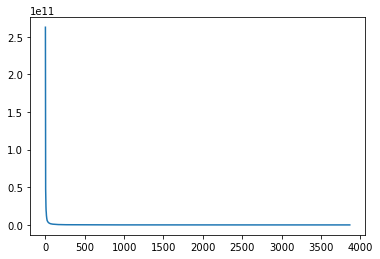

In [19]:
# Selecting K
x = range(len(Lambda))
plt.plot(x, Lambda)
# Based on the graph, I think K~50 will capture sufficient information


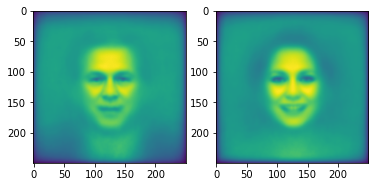

In [20]:
plt.subplot(1,2,1)
average_male = np.mean(male_faces, axis=1)
plt.imshow(average_male.reshape(250,250))

plt.subplot(1,2,2)
average_female = np.mean(female_faces,axis=1)
plt.imshow(average_female.reshape(250,250))


In [21]:
# Gender Detection Algorithm

def detectGender(K):
    pca_dims = v[:,0:K].T

    # project average male and female faces onto pca dimensions
    projected_avg_male = np.matmul(pca_dims,average_male) # 50 x 1
    projected_avg_female = np.matmul(pca_dims,average_female) # 50 x 1

    # make matrices of duplicated average male and female faces (to match dimensions of test dataset)
    #avg_male_matrix = np.asarray([projected_avg_male for i in range(1000)]).T
    #avg_female_matrix = np.asarray([projected_avg_female for i in range(1000)]).T

    # project entire test datasets onto pca dimensions
    projected_test_male = np.matmul(pca_dims, male_test) # 50 x 1000
    projected_test_female = np.matmul(pca_dims, female_test) # 50 x 1000

    correctness = []
    for i in range(1000):
        # do male faces
        test_male_face = projected_test_male[:,i]
        male_distance = np.sum(np.abs(test_male_face - projected_avg_male))
        female_distance = np.sum(np.abs(test_male_face - projected_avg_female))

        if male_distance < female_distance:
            correctness.append(1)
        else:
            correctness.append(0)

        # do female faces

        test_female_face = projected_test_female[:,i]
        female_distance = np.sum(np.abs(test_female_face - projected_avg_female))
        male_distance = np.sum(np.abs(test_female_face - projected_avg_male))

        if female_distance < male_distance:
            correctness.append(1)
        else:
            correctness.append(0)

    print("Accuracy for K = " + str(K) + ": " + str(np.sum(correctness)/len(correctness)))


    # print(np.shape(projected_test_male))
    # # compare test datasets to average male/female faces
    # male_scores_for_males = abs(projected_test_male - avg_male_matrix)
    # female_scores_for_males = abs(projected_test_male - avg_female_matrix)

    # whichGender_for_males = male_scores_for_males - female_scores_for_males
    # male_accuracy = np.sum(whichGender_for_males, axis=0) #calculate l1 norm by summing
    # print(male_accuracy[0:20])
    # male_accuracy = np.where(male_accuracy > 0, 1, 0) #if correct predicted male, set to 1, otherwise set to 0

    # print(np.sum(male_accuracy)/np.shape(male_accuracy))


    # female_scores_for_females = projected_test_female - avg_female_matrix
    # male_scores_for_females = projected_test_female - avg_male_matrix

    # whichGender_for_females = female_scores_for_females - male_scores_for_males
    # female_accuracy = np.sum(whichGender_for_females, axis=0) #calculate l1 norm by summing
    # print(female_accuracy)
    # female_accuracy = np.where(female_accuracy > 0, 1, 0) #if correct predicted male, set to 1, otherwise set to 0
    # print(np.sum(female_accuracy)/np.shape(female_accuracy))
    


detectGender(50)
detectGender(100)
detectGender(200)
detectGender(300)

# Increasing the K value increases the accuracy but after K = 50 (our smallest K value!) the benefit is quite minimal


Accuracy for K = 50: 0.5745
Accuracy for K = 100: 0.575
Accuracy for K = 200: 0.5845
Accuracy for K = 300: 0.59


In [22]:
def detectGenderBetter(K):  
    pca_dims = v[:,0:K].T # 50 x 62500
    #male_faces # 62500 x 1934

    # project average male and female faces onto pca dimensions
    projected_training_male = np.matmul(pca_dims,male_faces) # 50 x 1934
    projected_training_female = np.matmul(pca_dims,female_faces) # 50 x 1934

    # project entire test datasets onto pca dimensions
    projected_test_male = np.matmul(pca_dims, male_test) # 50 x 1000
    projected_test_female = np.matmul(pca_dims, female_test) # 50 x 1000

    correctness = []
    for i in range(1000):
        # do male faces
        test_male_face = projected_test_male[:,i] # 50 x 1
        test_male_matrix = np.asarray([test_male_face for i in range(1934)]) # 1934 x 50

        male_distance = np.sum(np.abs(test_male_matrix.T - projected_training_male))
        female_distance = np.sum(np.abs(test_male_matrix.T - projected_training_female))

        if male_distance < female_distance:
            correctness.append(1)
        else:
            correctness.append(0)

        # do female faces
        test_female_face = projected_test_female[:,i] # 50 x 1
        test_female_matrix = np.asarray([test_female_face for i in range(1934)]) # 1934 x 50

        female_distance = np.sum(np.abs(test_female_matrix.T - projected_training_female))
        male_distance = np.sum(np.abs(test_female_matrix.T - projected_training_male))

        if female_distance < male_distance:
            correctness.append(1)
        else:
            correctness.append(0)

    print("Accuracy for K = " + str(K) + ": " + str(np.sum(correctness)/len(correctness)))


    # correctness = []
    # for i in range(1000):
    #     # do male faces
    #     test_male_face = projected_test_male[:,i]
    #     male_distance = np.sum(np.abs(test_male_face - projected_avg_male))
    #     female_distance = np.sum(np.abs(test_male_face - projected_avg_female))

    #     if male_distance < female_distance:
    #         correctness.append(1)
    #     else:
    #         correctness.append(0)

    #     # do female faces

    #     test_female_face = projected_test_female[:,i]
    #     female_distance = np.sum(np.abs(test_female_face - projected_avg_female))
    #     male_distance = np.sum(np.abs(test_female_face - projected_avg_male))

    #     if female_distance < male_distance:
    #         correctness.append(1)
    #     else:
    #         correctness.append(0)

    # print("Accuracy for K = " + str(K) + ": " + str(np.sum(correctness)/len(correctness)))
        
    
    # # compare test datasets to average male/female faces
    # male_scores_for_males = abs(projected_test_male - avg_male_matrix)
    # female_scores_for_males = abs(projected_test_male - avg_female_matrix)

    # whichGender_for_males = male_scores_for_males - female_scores_for_males
    # male_accuracy = np.sum(whichGender_for_males, axis=0) #calculate l1 norm by summing
    # print(male_accuracy[0:20])
    # male_accuracy = np.where(male_accuracy > 0, 1, 0) #if correct predicted male, set to 1, otherwise set to 0

    # print(np.sum(male_accuracy)/np.shape(male_accuracy))


    # female_scores_for_females = projected_test_female - avg_female_matrix
    # male_scores_for_females = projected_test_female - avg_male_matrix

    # whichGender_for_females = female_scores_for_females - male_scores_for_males
    # female_accuracy = np.sum(whichGender_for_females, axis=0) #calculate l1 norm by summing
    # print(female_accuracy)
    # female_accuracy = np.where(female_accuracy > 0, 1, 0) #if correct predicted male, set to 1, otherwise set to 0
    # print(np.sum(female_accuracy)/np.shape(female_accuracy))
    


detectGenderBetter(50)
detectGenderBetter(100)
detectGenderBetter(200)
detectGenderBetter(300)

# Accuracy went up slightly initially as K went from 50 to 100 but then went down more steeply. 

Accuracy for K = 50: 0.597
Accuracy for K = 100: 0.603
Accuracy for K = 200: 0.5875
Accuracy for K = 300: 0.5795


In [ ]:
print(np.shape(v))
print(np.shape(v[:,0]))
print(np.shape(v[:,0:20]))


**You are ready to submit in Canvas!**

4 easy steps to submit your lab:

1.   Go to "File" - "Download .ipynb"
2.   Click on "Share" option on top right - Click on "copy link" option. Make sure your permission is set to "Anyone on the internet with this link can view"
3.   Upload the ".ipynb" file obtained from Step (1) as instructed in the homework document. If it is too big, zip it before uploading.
4.   In the text comments on Canvas, paste the link obtained from Step (3).

That's it!

In short, we want to have one link, one .ipynb and one 'HW1_yourJHID.zip' containing all the required outputs.

Please suffix your colab file and the zip file with your _jhID, eg: HW2_myjhID12
